# Домашнее задание 2

В этом домашнем задании мы поупражняемся с ETS-моделью и STL-разложением. Сначала коротко про данные.

Представьте себе стандартный банкомат, который работает только на выдачу. Его нужно периодически пополнять наличностью, чтобы он функционировал непрерывно. Однако выезд инкассаторов является делом хлопотным и недешёвым, так что хотелось бы не гонять их лишний раз заполнять наполовину полный банкомат. Хотелось бы научиться предсказывать спрос людей на наличность в банкомате, чтобы можно было предсказывать время, когда количество денег в банкомате снизится до минимально допустимой величины. Этим мы и займёмся. Для простоты возьмём один конкретный банкомат. Нам доступны объёмы выдачи в банкомате по дням.

In [1]:
import pandas as pd
import datetime
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
import seaborn as sns
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
import numpy as np
import requests
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.model_selection import SlidingWindowSplitter, ForecastingGridSearchCV
from sktime.forecasting.base import ForecastingHorizon
from sktime.performance_metrics.forecasting import MeanAbsoluteError
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sktime.forecasting.compose import make_reduction
from sklearn.metrics import mean_absolute_error
from statsmodels.stats.diagnostic import acorr_ljungbox
from sktime.utils.plotting import plot_series
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.tsa.stattools import adfuller
import warnings

warnings.filterwarnings("ignore")

%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 23, 15
plt.rcParams['font.size'] = 12
sns.set_style('darkgrid')

##### 1) Загрузка данных и визуальный анализ (1 балл)

Загрузите данные из файла atm.csv. Рекомендуется для нормальной работы некоторых фукнций перевести индекс в тип PeriodIndex. Например, можно создать date_range с нужной частотой. Изобразите временной ряд, его автокорреляции и частные автокорреляции. Что вы можете сказать о структуре ряда? Присутствует ли в нём тренд? Сезонность? Цикличность? Стационарность?

In [2]:
atm_df = pd.read_csv('atm.csv', header=0, names=['Date','target']).iloc[:,1:]

In [3]:
# создаю новый индекс типа PeriodIndex

start = datetime.datetime(2015,1,1)
end = datetime.datetime(2017,9,12)


idx2 = pd.date_range(start, end, freq='D')
atm_df.set_index(idx2, inplace=True)
atm_df.index.rename('Date', inplace=True)

Text(0, 0.5, 'Выдача наличных')

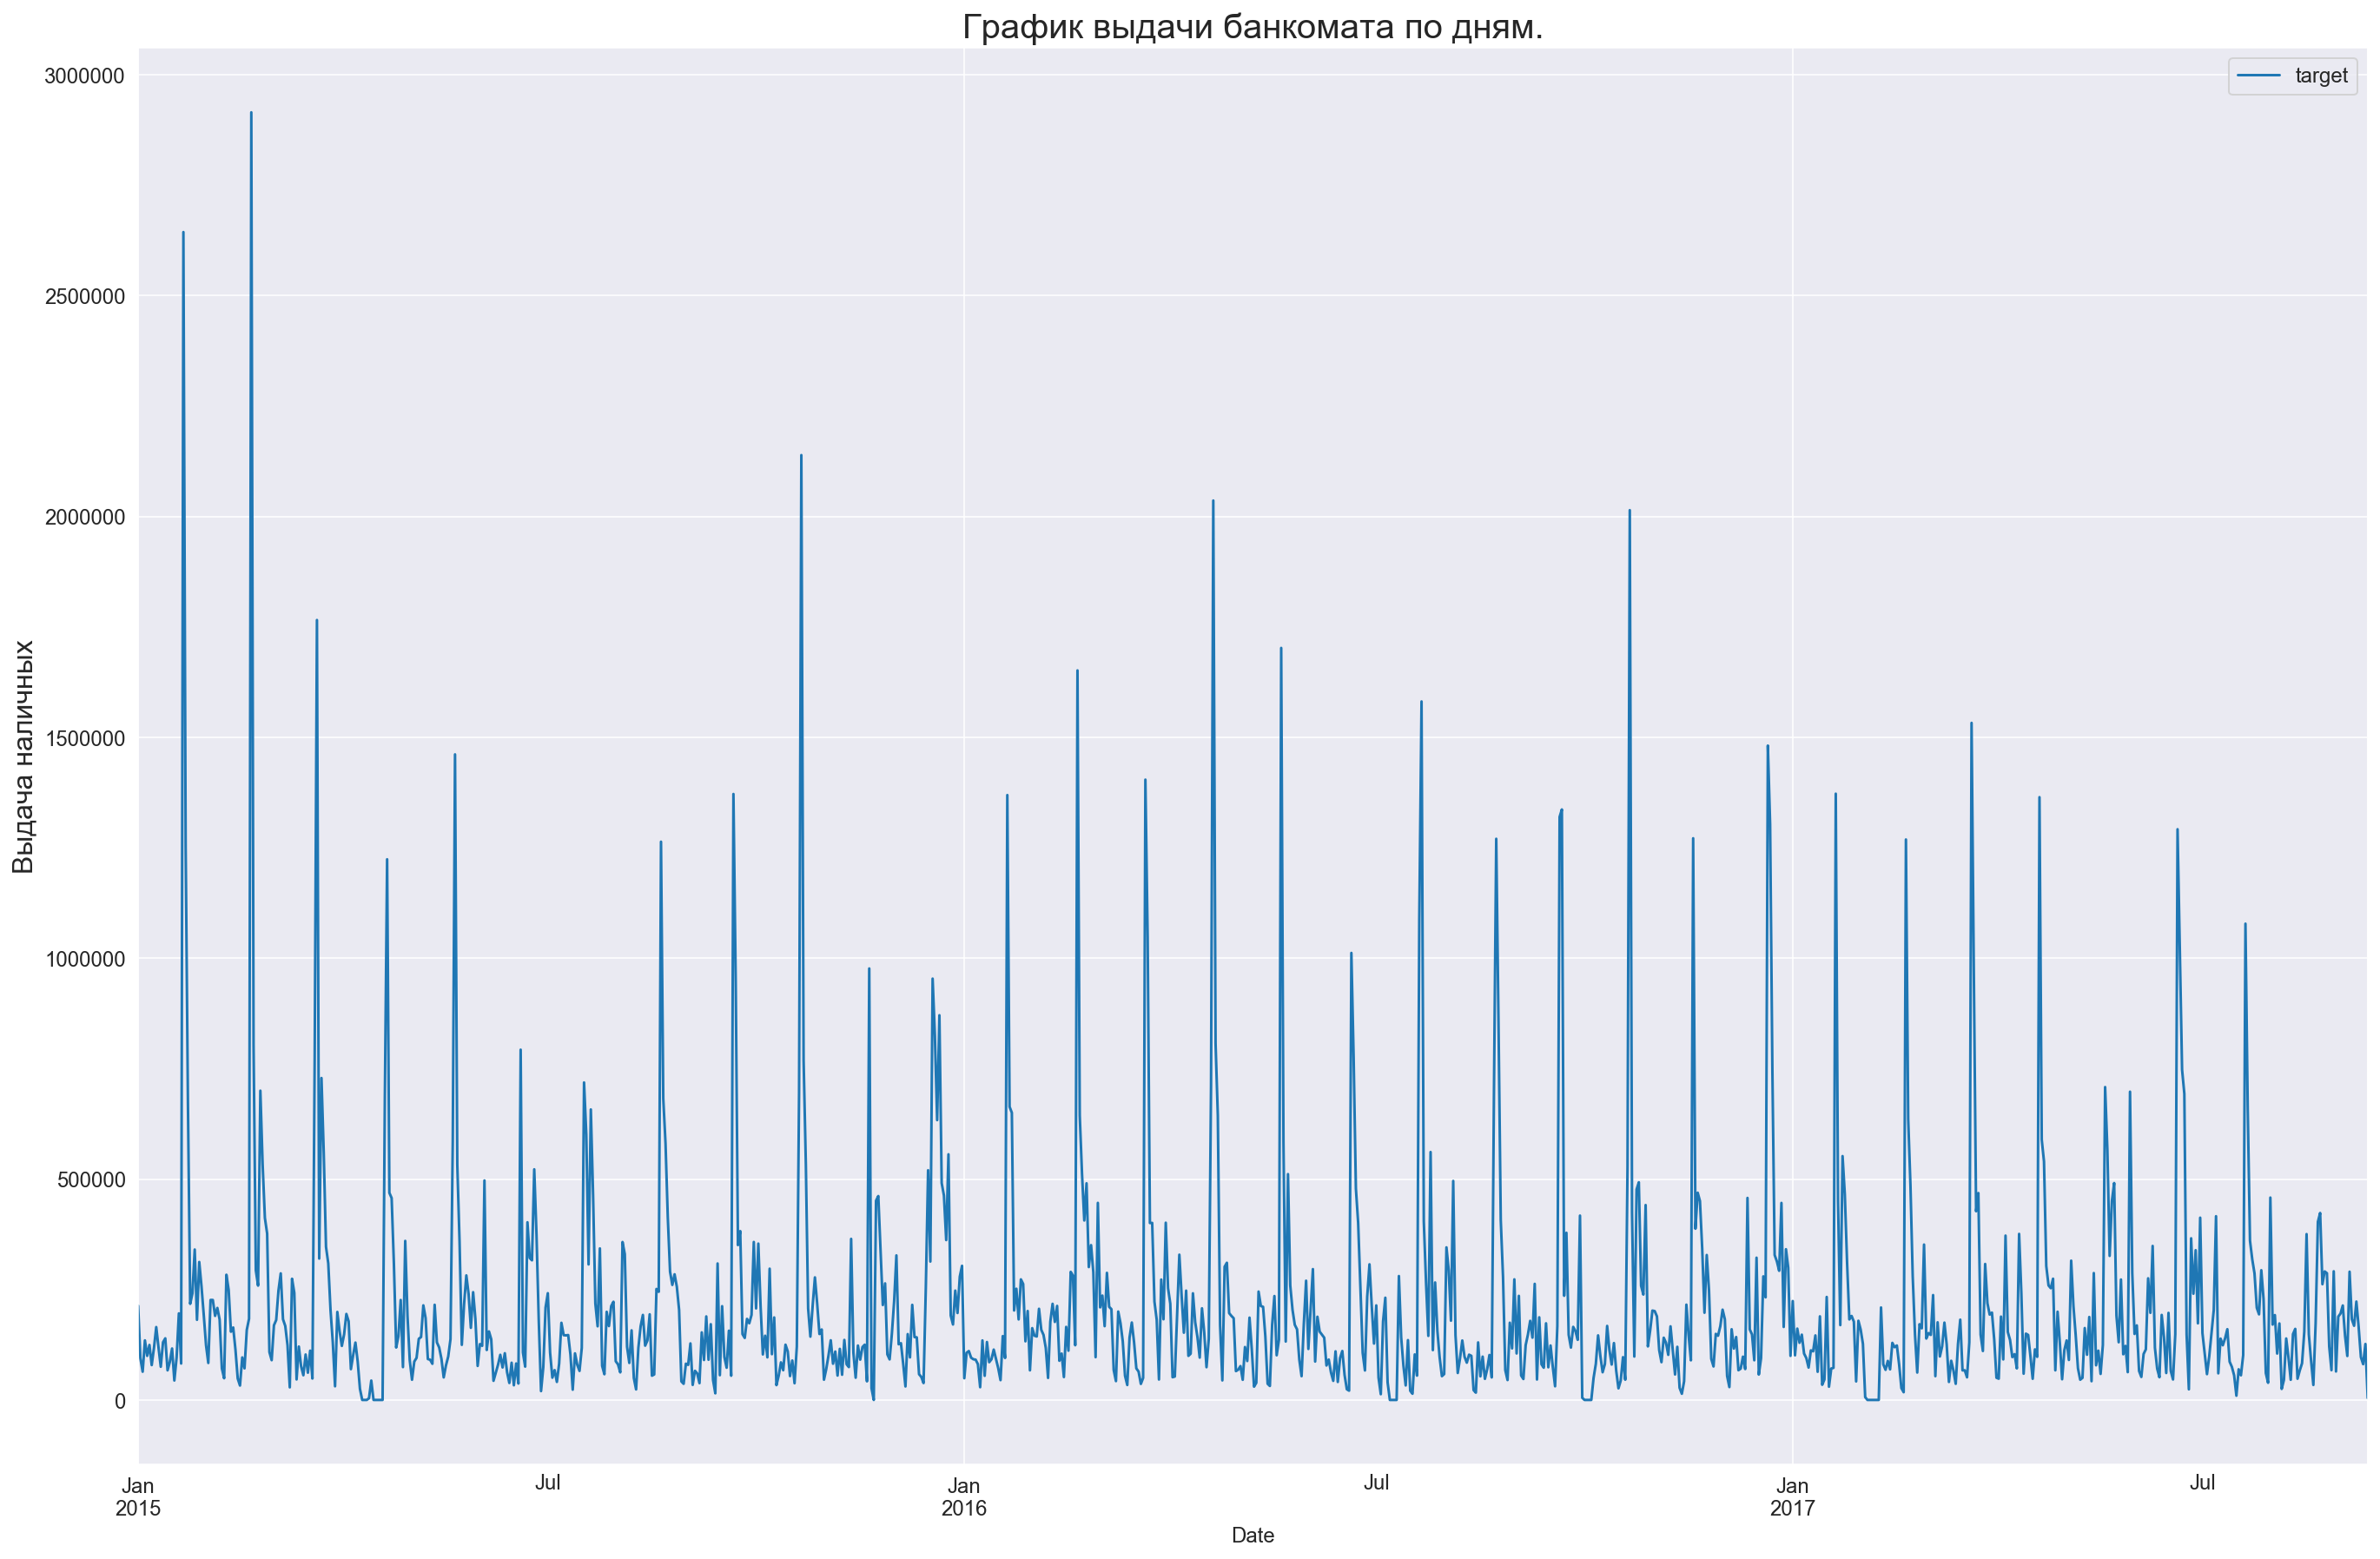

In [4]:
atm_df.plot()
plt.title('График выдачи банкомата по дням.', fontsize = 20)
plt.ylabel('Выдача наличных', fontsize = 16)

Ряд не является стационарным из-за снижающейся с течением времени дисперсии. Тренд в явном виде отсутсвует. Наблюдается месячная сезонность. Присутсвует сильная цикличность ряда.

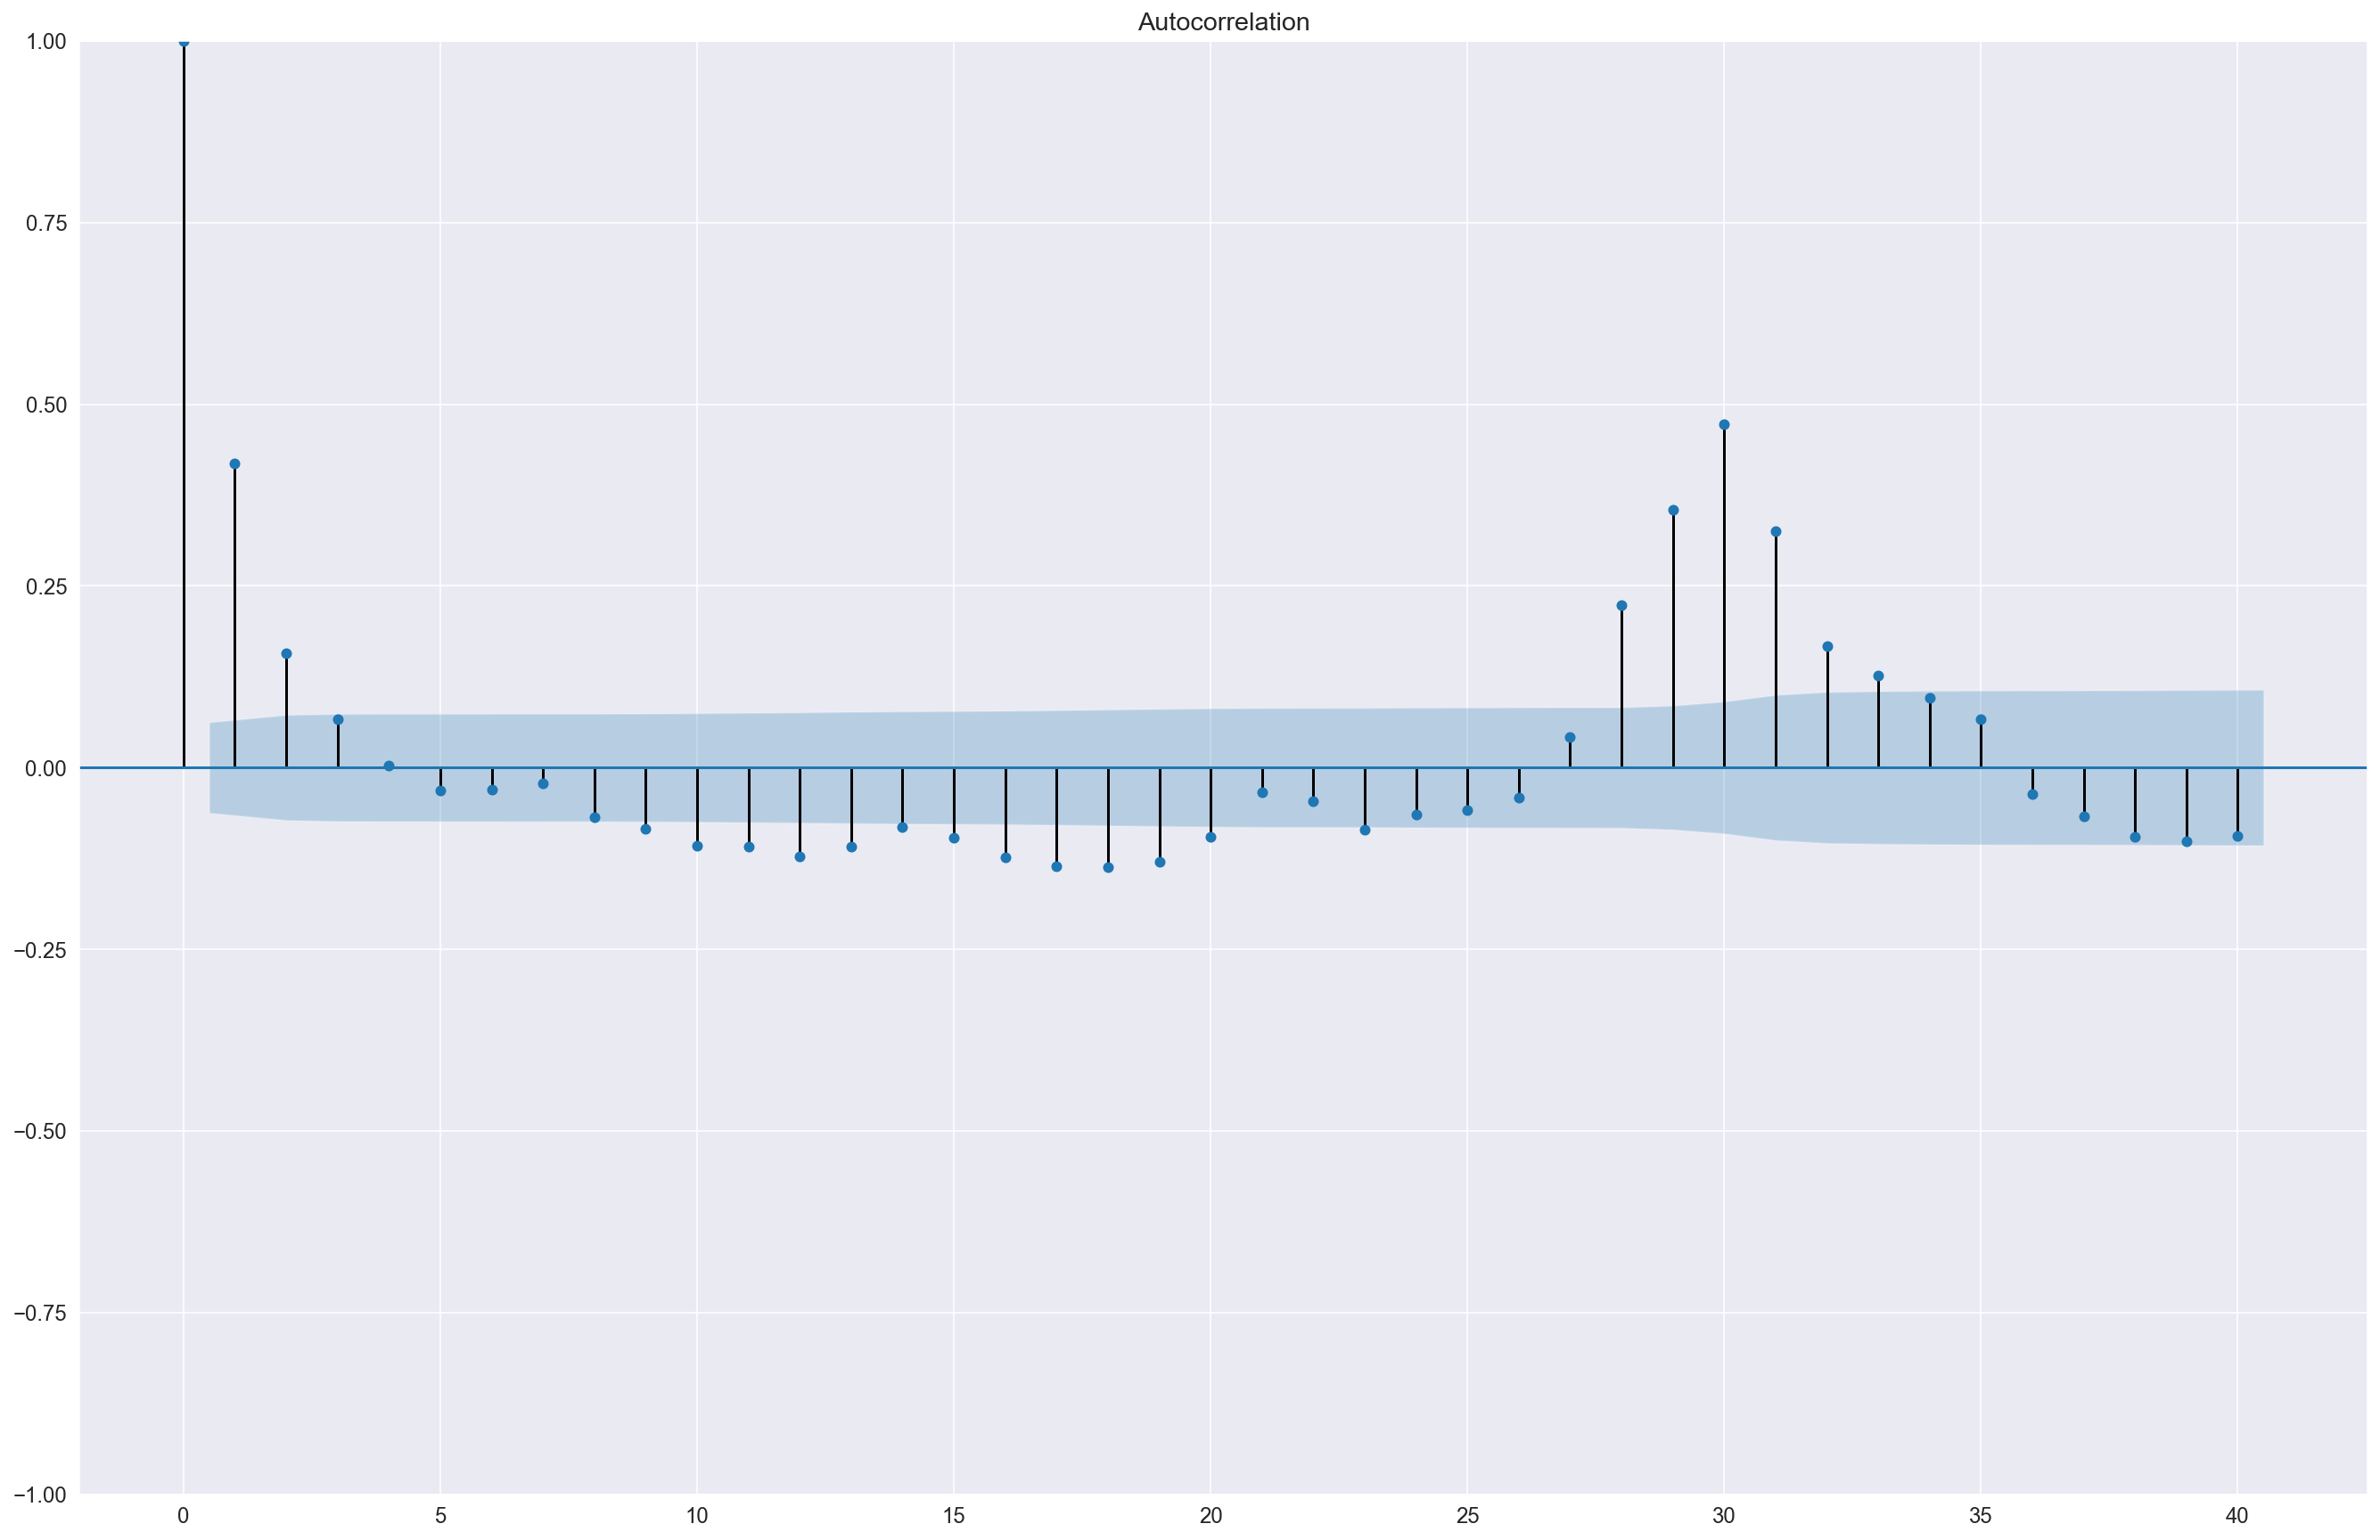

In [5]:
plot_acf(atm_df, lags=40);

По автокорреляционной функции можно отметить сильную корреляцию с 28-31 лагами, что подтверждает месячную сезонность данных

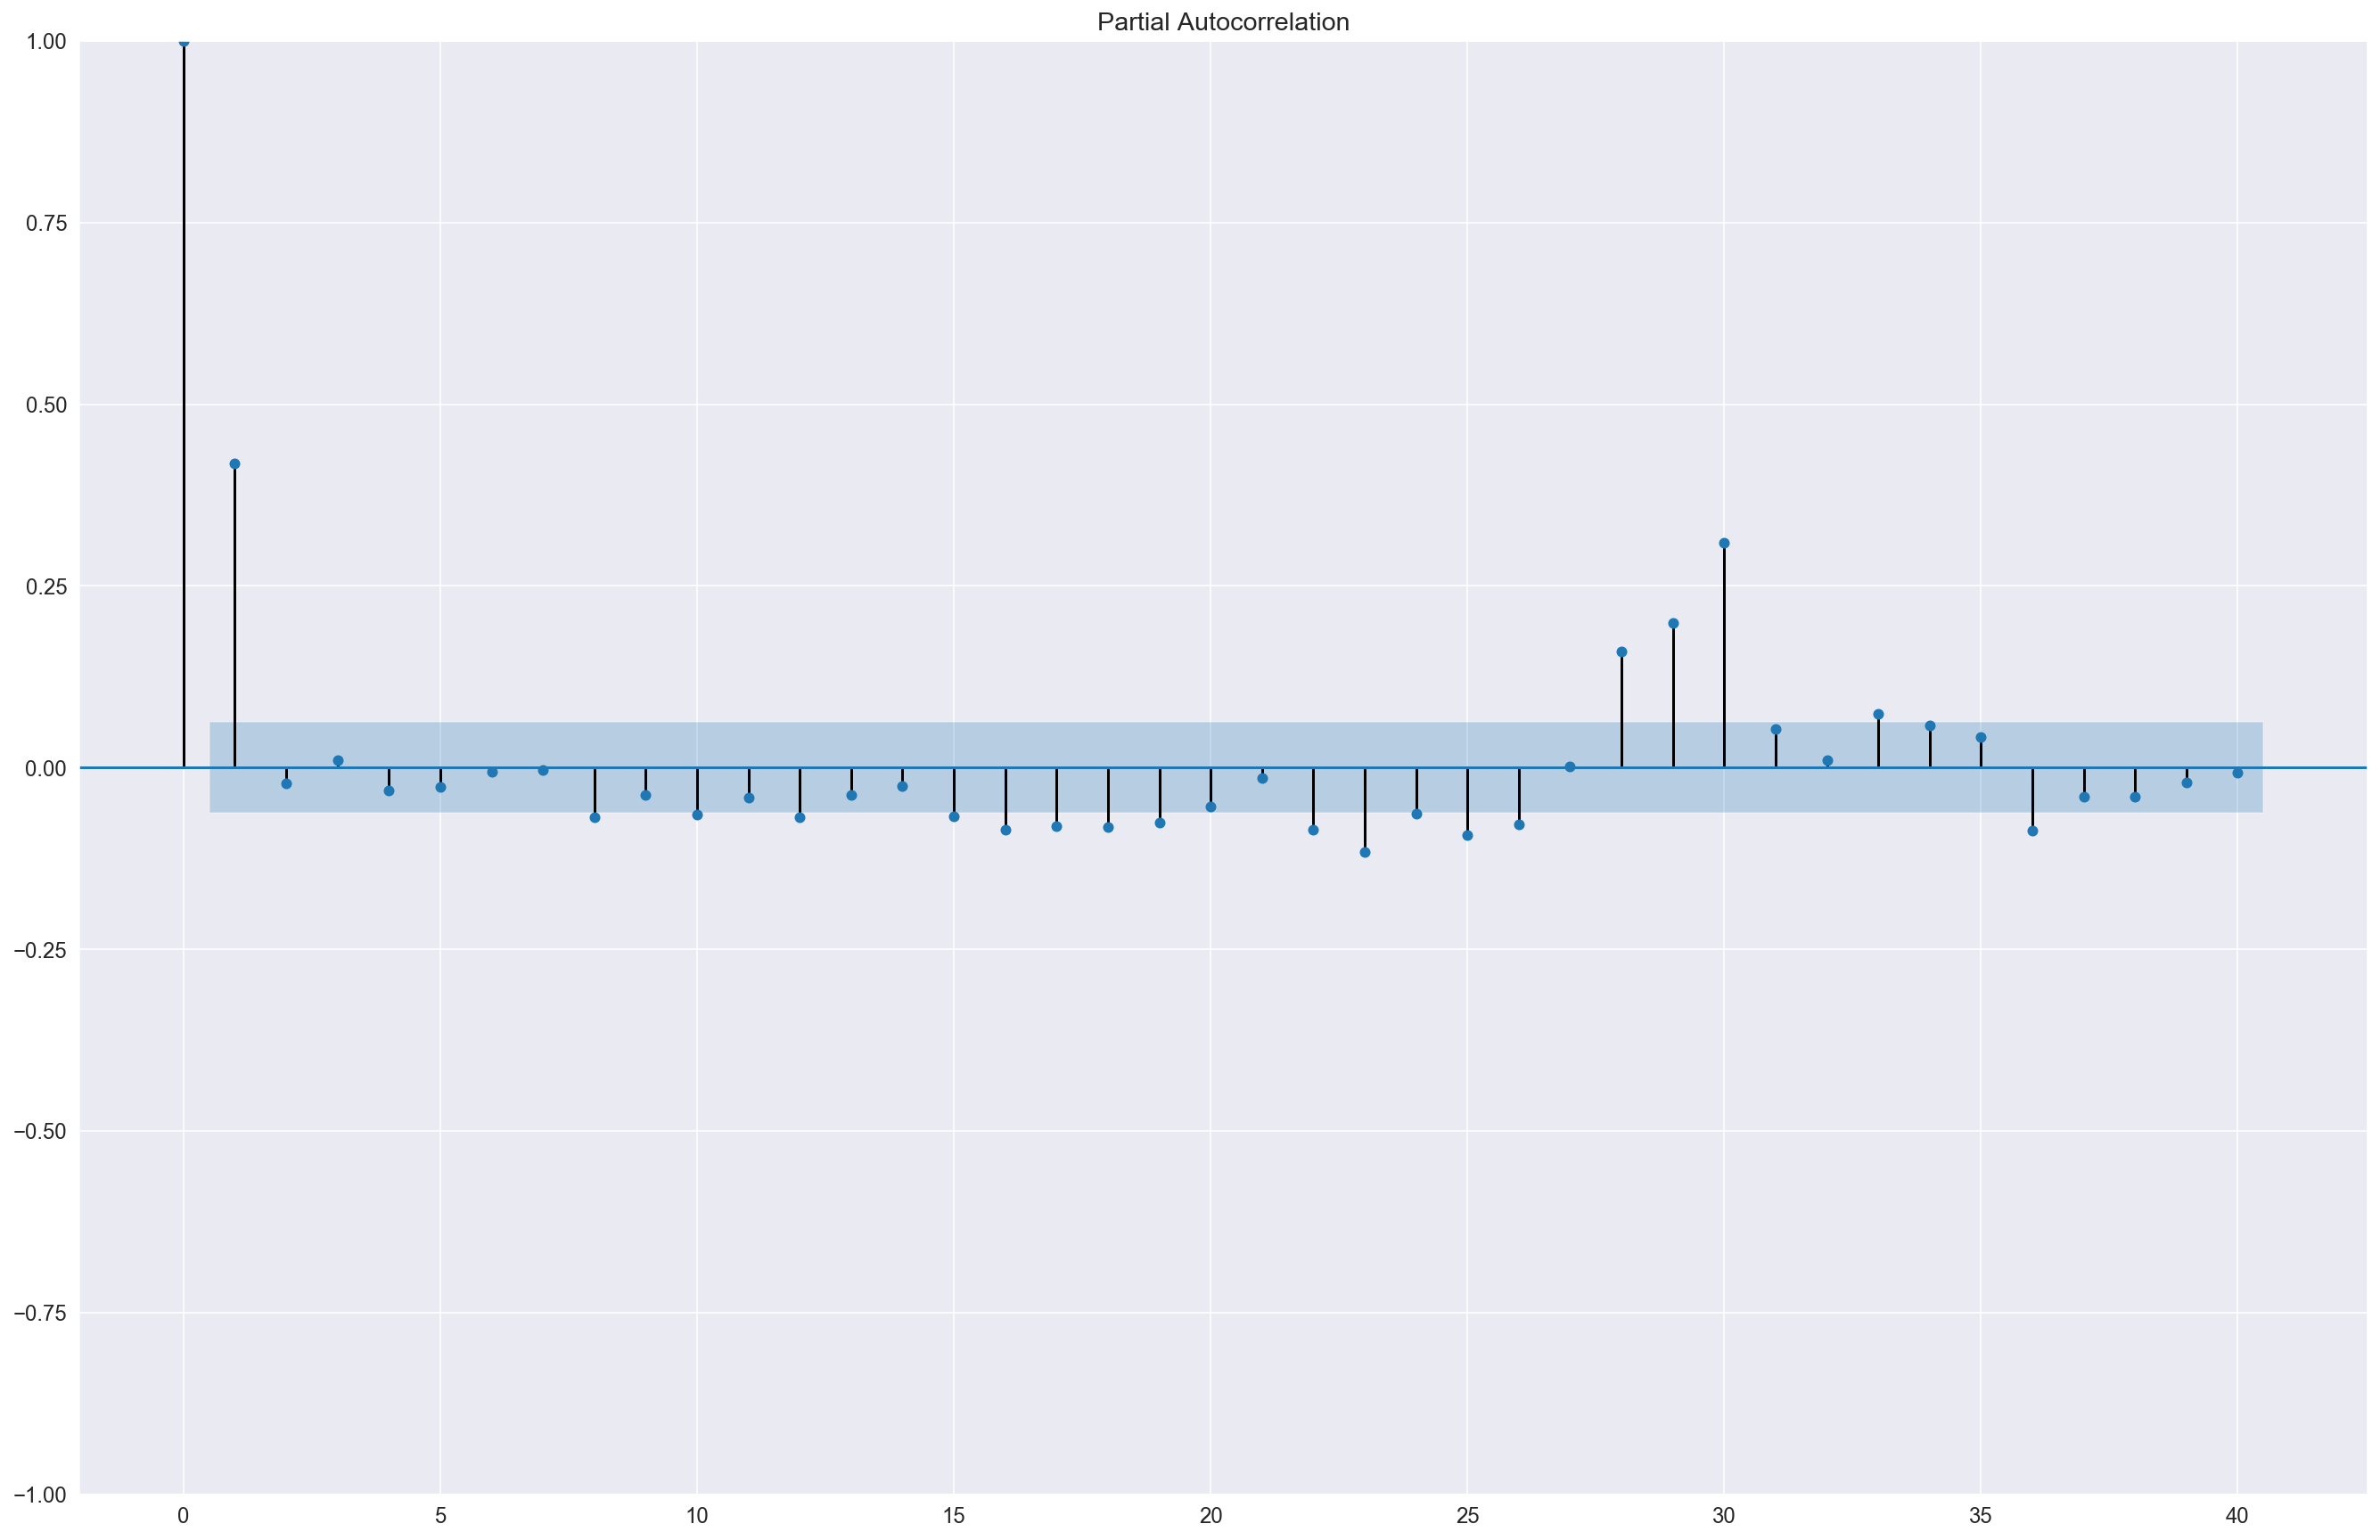

In [6]:
plot_pacf(atm_df, lags=40);

##### 2) Предобработка данных (0.5 балла)

Разбейте данные на трейн и тест. Размер теста: последние 30 дней.

Как легко заметить, данные неотрицательны. Но давайте на случай использования мультипликативных ETS-моделей их децентрируем. К тренировочной части прибавьте произвольную небольшую константу (например 100 рублей). Обратите внимание, что константу придётся вычесть из прогнозов итоговой модели при подсчёте метрик относительно теста.

Дополнительно можете произвести обратимые преобразования, которые сочтёте необходимыми.

In [7]:
atm_df.shape[0]

986

In [8]:
y_train, y_test = atm_df[:956], atm_df[956:]

y_train += 100  # поправка на случай, если ликвидность в банкомате закончится. Удобнее обучать модель. 

## Покомпонентное прогнозирование

В данном разделе мы попробуем пофильтровать ряд с помощью двух моделей: STL-разложения и ETS-модели.

### Блок 1. STL

##### Разложение (0.3 балла)

Начнём с STL. Примените на трейне STL-разложение. В качестве параметра period возьмите самый сильный лаг автокорреляций. Визуализируйте отдельные компоненты.

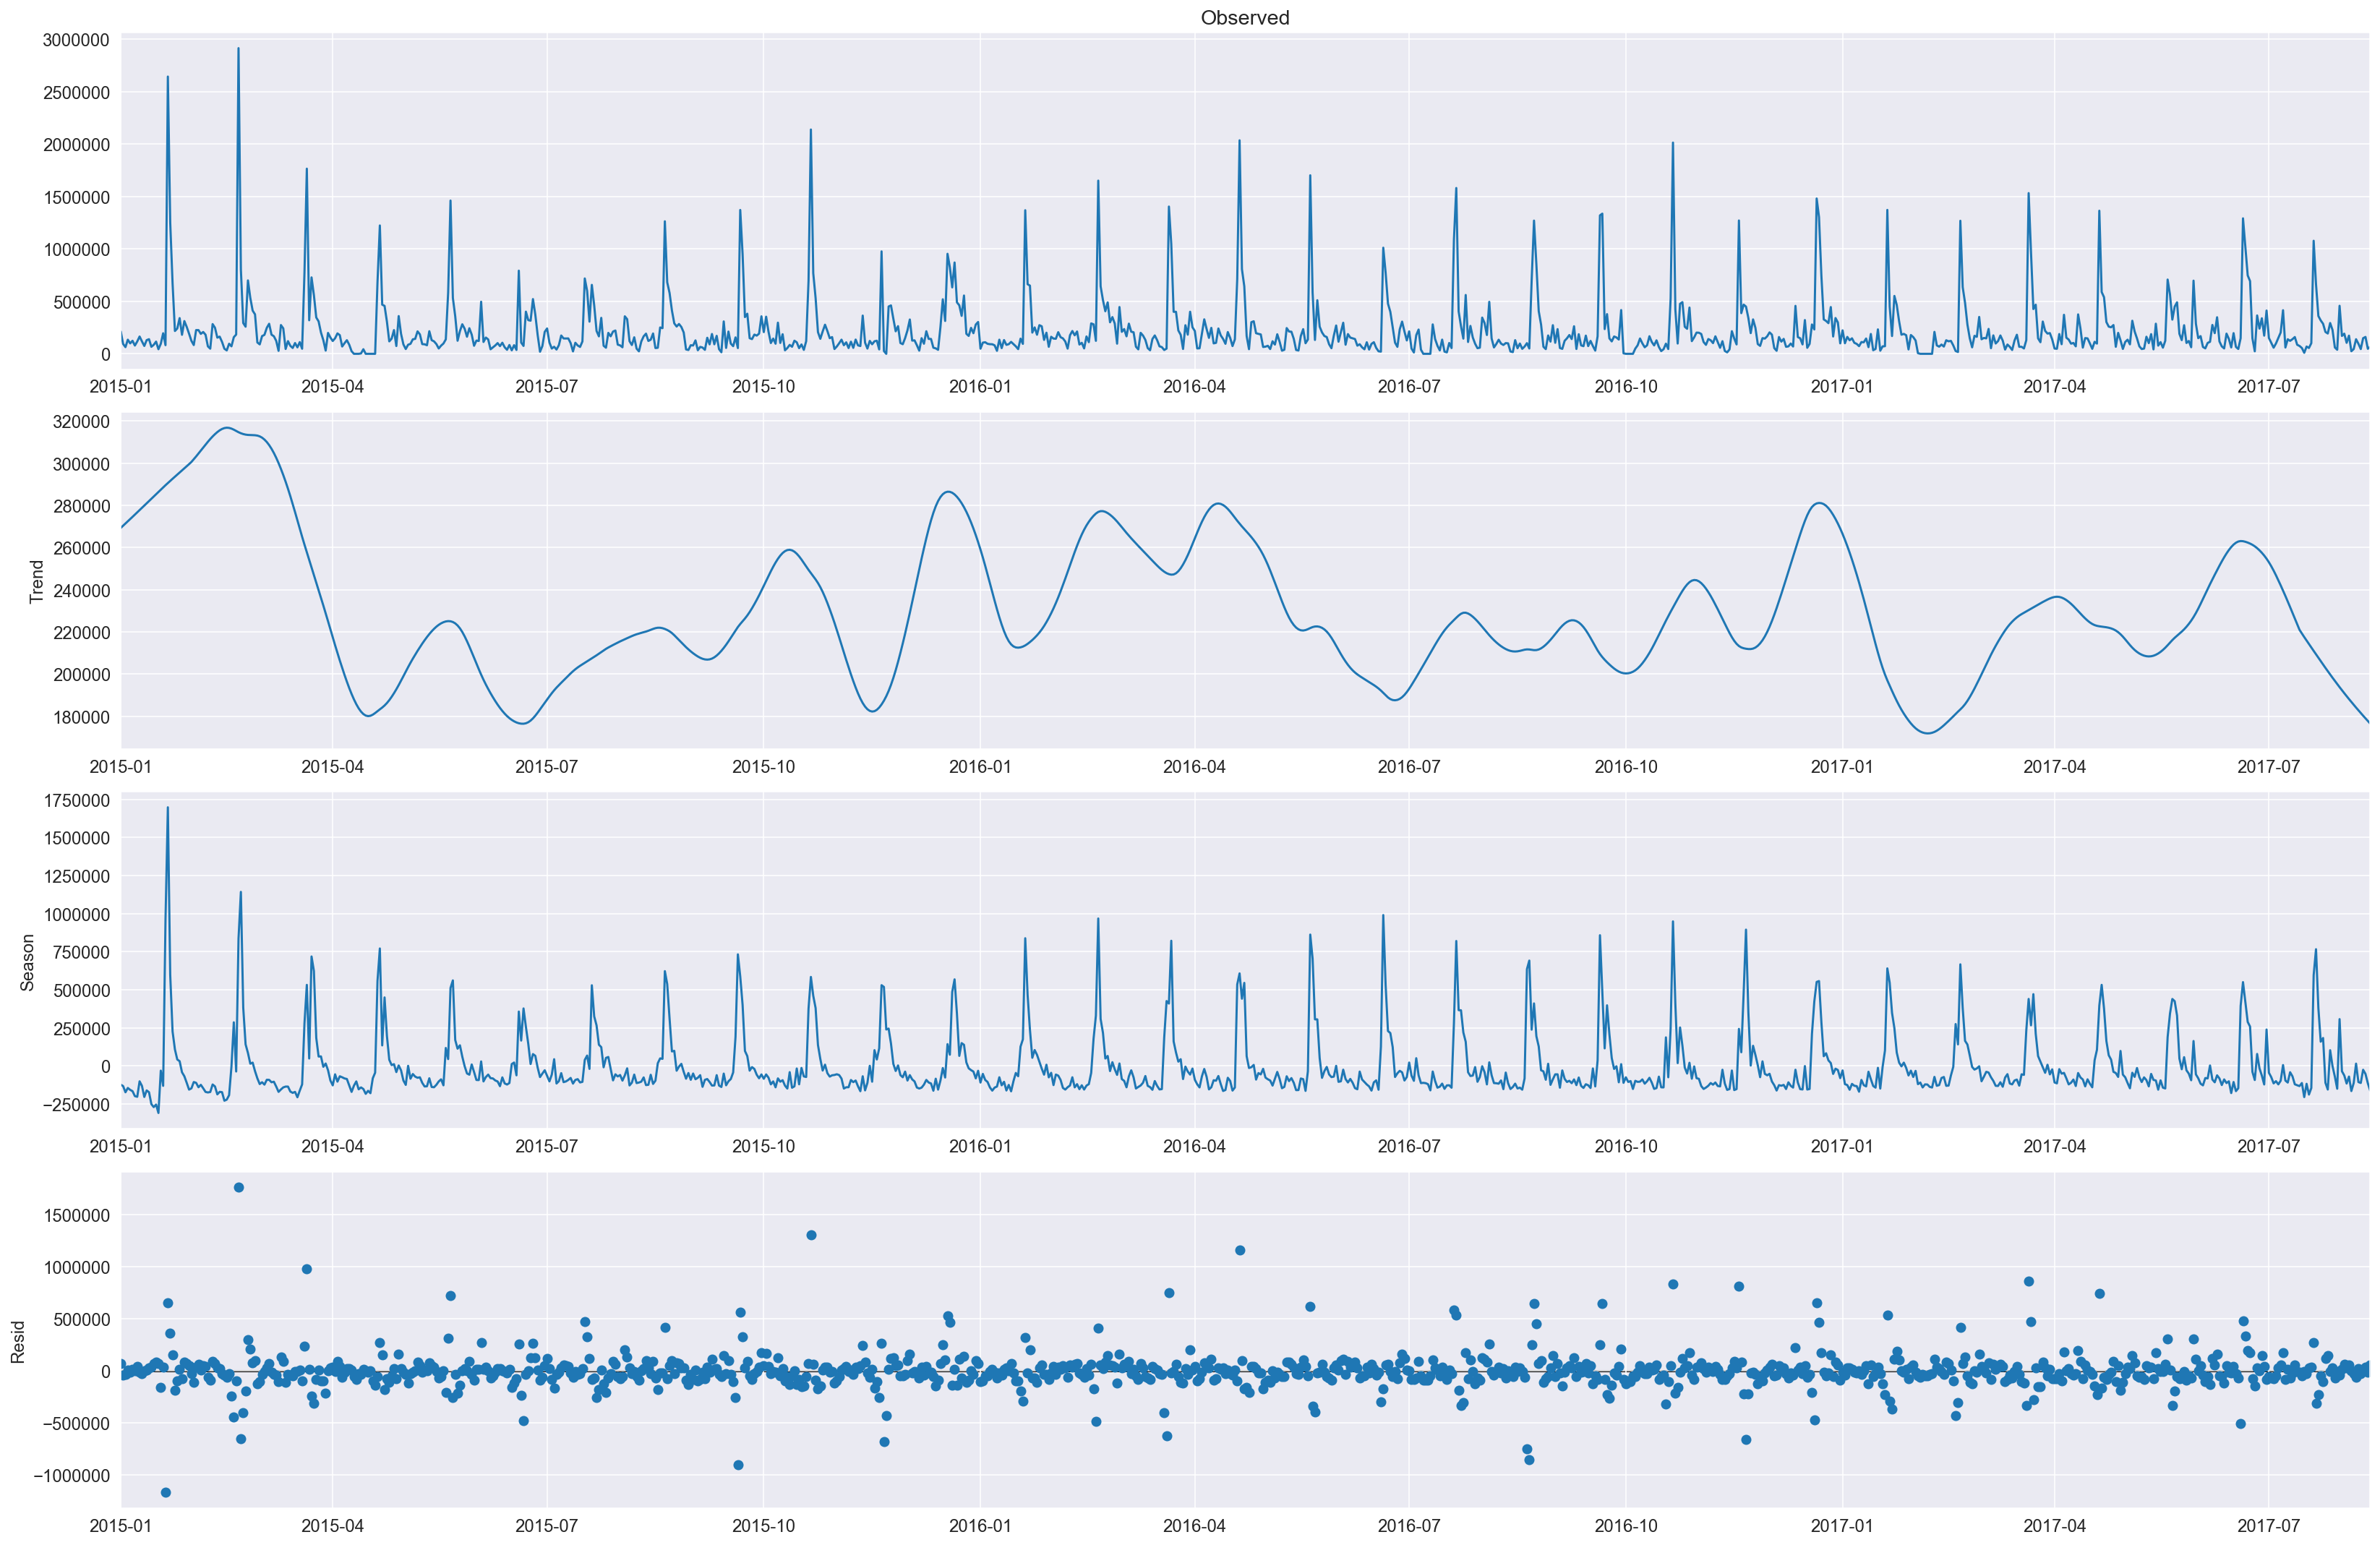

In [9]:
stl = STL(y_train, period=31).fit()
stl.plot();

plt.rcParams["figure.figsize"] = (14,7)

In [10]:
# выделил отдельные компоненты в модели: тренд, сезонность и остаток. 

trend = stl.trend
seasonality = stl.seasonal
residuals = stl.resid

##### Прогнозирование отдельных компонент (0.6 балла)

Возьмём выделенные из STL компоненты. Постройте какие-нибудь простые модели (без фичей) для тренда и сезонности.

Например, для тренда можно взять модель полиномального тренда из sktime. Для сезонности можно использовать NaiveForecaster с указанием периодичности. Спрогнозируйте каждую компоненту 30 шагов (по 0.3 за каждую компоненту).

In [11]:
# воспользовался моделью полиномиального тренда. 

polynom_forecaster = PolynomialTrendForecaster(degree = 3)
polynom_forecaster.fit(trend)
polynom_prediction = polynom_forecaster.predict(y_test.index) - 100

# для прогнозирования сезонности использовал наивную модель.
naive_forecaster = NaiveForecaster(strategy='last', sp = 31)
naive_forecaster.fit(seasonality)
naive_prediction = naive_forecaster.predict(y_test.index) - 100

#### Прогнозирование остатков. 

##### Подготовка данных (0.9 балла)

Достанем временной ряд остатков из STL-разложения. Построим отдельную модель с остатками STL в качестве таргета и потом сложим с прогнозами отдельных компонент из предыдущего шага. Получим этакий бутерброд. Прогнозируем отдельно на 30 шагов каждую компоненту: тренд, сезонность и ошибку, а потом суммируем прогнозы.

Многошаговый прогноз остатков потребует уже модели с фичами. По сути эта задача эквивалентна многошаговому прогнозированию из ДЗ-1. В этот раз вам не будет дано конкретных указаний по генерации переменных. Но будет выдана дополнительная информация о банкомате. Можете её использовать, можете нет, на ваше усмотрение.

Расположение: ул Крымский Вал, 9стр45

Дополнительная информация: ГАУК культуры города Москвы ЦПКиО им. М.Горького

Широта: 55.73259

Долгота: 37.600891

Также в помощь прилагается файл с различными календарными фичами (events.csv), чтобы не повторять в этой домашке то же самое, что в прошлой. Можете использовать любые фичи из этого файла, но для засчитывания пункта необходимо придумать минимум три фичи (по 0.3 за каждую), не входящие в приложенный файл. Каждую используемую фичу (не важно, из файла или придуманную вами) необходимо кратко обосновать. Не забывайте учитывать потенциальные утечки. За их наличие балл также может быть снижен.

Результатом пункта должны быть вектор y_train и матрица X_train для модели остатков.

In [12]:
# создаю матрицу объект-признак. 
X_train = pd.read_csv('events.csv', index_col=0)
X_train.index = pd.to_datetime(X_train.index, dayfirst=True)
X_train = X_train[X_train.index >= '2015-01-01']
X_train = X_train[X_train.index < '2017-09-13']

# снижаю размерность матрицы за счет объединения малозначимых признаков в группы. 
X_train['пн-чт'] = X_train.loc[:,'пн':'чт'].sum(axis=1)
X_train['зима'] = X_train.loc[:,'январь':'февраль'].sum(axis=1) + X_train.loc[:,'декабрь']
X_train['весна'] = X_train.loc[:,'март':'май'].sum(axis=1)
X_train['лето'] = X_train.loc[:,'июнь':'август'].sum(axis=1)
X_train['осень'] = X_train.loc[:,'сентябрь':'ноябрь'].sum(axis=1)
X_train['предновогодние дни'] = X_train.loc[:,'27-Дек':'30-Дек'].sum(axis=1)

# форматирую матрицу. 
X_train.drop(['последний день месяца','пн','вт','ср','чт',\
              'январь','февраль','март','фпрель','май','июнь','июль','август','сентябрь',\
              'октябрь','ноябрь','декабрь','предвыходной'], axis=1,inplace=True)

In [13]:
# 1-й признак - инфляция. Было бы лучше взять инфляционные ожидания, но их количественной в открытом доступе я не нашел. 

inf = pd.read_csv('inflation.csv', sep=';', index_col=0)
inf.index = pd.to_datetime(inf.index, dayfirst=True)

X_train = X_train.merge(inf, how='left', on='Date') 

# мои данные по инфляции - ежемесяные, поэтому я их линейно привожу к дневным и сдвигаю на 1 шаг. 

X_train['Inflation'] = X_train['Inflation'].interpolate(method='linear').shift(1)

In [14]:
# 2-признак - лаги таргета. Использовал те их них, корреляция которых наибольшая.

X_train['y_L1'] = y_train.shift(1)
X_train['y_L28'] = y_train.shift(28)
X_train['y_L29'] = y_train.shift(29)
X_train['y_L30'] = y_train.shift(30)
X_train['y_L31'] = y_train.shift(31)

In [15]:
# 3-й признак - цена нефти марки Брент. Россия - сырьевая экономика, зависящая от цен на нефть.
# Низкие цены означают дефицит бюджета, который восполняется через увеличение налоговых сборов. 
# Реальное благосостояние людей снижается, а в тяжелые времена все начинают массово снимать наличку. 

brent = pd.read_csv('brent.csv', names=['ticker','per','Date','time','open','high','low','close','vol'],\
                    header=0, index_col=2)
brent.index = pd.to_datetime(brent.index, dayfirst=True)
brent = brent.loc[:,'close']

X_train = X_train.merge(brent, how='left',on='Date')

X_train['close'] = X_train['close'].fillna(method='ffill').shift(1) # заполняю пропуски в выходные последним значением. 

In [16]:
# избавляюсь от пропусков и сопоставляю размерности матрицы признаков с вектором ответов. 

X_train = X_train.dropna(axis=0)
residuals = residuals[31:]

#### Кросс-валидация

Теперь займёмся подбором оптимальной модели остатков STL на трейне. Для этого используем кросс-валидацию.

##### Реализация метода (0.6 балла)

Так как нас интересуют именно многошаговые прогнозы, стандартная кросс-валидация нам не подойдёт. Выберите любой из двух методов кросс-валидации временных рядов (скользящее или расширяющееся окно) на ваше усмотрение.

 Реализуйте класс, который будет по входным параметрам окна выдавать индексы всех фолдов. По поведению можно ориентироваться на знакомый вам k-fold. Хорошей практикой будет возвращать в методе split генератор, хотя это и не обязательно. На каждом фолде модель будет обучаться на трейне и делать многошаговый прогноз на тест. Позаботьтесь о том, чтобы ширина окна была соотнесена в логичной пропорции с горизонтом прогнозирования. Ширина окна 35 при горизонте 30 -- сомнительная практика.


In [17]:
# кросс-валидация со скользящим окном. 

class CustomCrossVal:
    def __init__(self, window_size = 100, step=30):
        
        self.window_size = window_size
        self.step = step
        
    def split(self, X):
        
        item = self.window_size
        lower_bound = 0
        
        for item in range(self.window_size, X.shape[0], self.step):
            
            train_index = np.arange(lower_bound, item - self.step)
            test_index = np.arange(item - self.step, item)
            
            lower_bound += self.step
            
            yield train_index, test_index 

##### Отбор моделей (0.5 балла)

Выберите 3-4 модели-кандидата и отберите с помощью реализованной вами кросс-валидации наилучшую. Можно использовать разные модели либо разные наборы фичей. Метрика: MAE.

### Lasso regression

In [18]:
model1 = Lasso()
model2 = GradientBoostingRegressor()
model3 = RandomForestRegressor()

In [19]:
X_train_lasso = X_train.copy()

In [20]:
# определяю столбцы, которые необходимо масшабировать

numeric = X_train_lasso.loc[:,'Inflation':].columns

# применяю масштабирование

scaler = StandardScaler()

X_train_lasso[numeric] = scaler.fit_transform(X_train_lasso[numeric])

In [21]:
# функция расчета ошибки модели с использованием кросс-валидации. 

def Custom_CrossVal_func(regressor, X_train, y_train):

    cv = CustomCrossVal()
    mae = []

    for i, j in cv.split(X_train):
    
        X_train_mod, y_train_mod = X_train.iloc[i], y_train.iloc[i]
        X_test_mod, y_test_mod = X_train.iloc[j], y_train.iloc[j]
    
        forecaster = make_reduction(estimator = regressor, strategy = 'direct')
        fh = ForecastingHorizon(y_test_mod.index, is_relative=False)
        
        forecaster.fit(y = y_train_mod, X = X_train_mod, fh = fh)
        y_pred = forecaster.predict(X = X_test_mod, fh = fh)
        mae.append(mean_absolute_error(y_test_mod, y_pred))
        
    return print('Средняя абсолютная ошибка алгоритма:','%.2f'%np.mean(mae))

In [22]:
# измеряем среднюю абсолютную ошибку Lasso.

Custom_CrossVal_func(regressor = Lasso(), X_train = X_train_lasso, y_train = residuals)

Средняя абсолютная ошибка алгоритма: 270635.31


In [23]:
# прогнозирование остатков с помощью градиентного бустинга

Custom_CrossVal_func(regressor = GradientBoostingRegressor(), X_train = X_train, y_train = residuals)

Средняя абсолютная ошибка алгоритма: 135427.46


In [24]:
# прогнозирование остатков с помощью случайного леса.

Custom_CrossVal_func(regressor = RandomForestRegressor(), X_train = X_train, y_train = residuals)

Средняя абсолютная ошибка алгоритма: 117355.91


##### Прогноз моделей (0.5 балла)

Обучите наилучшую модель на всём трейне и постройте прогноз на тестовый период. Используйте любую из многошаговых стратегий, но прямая будет самым простым решением. 

In [25]:
# наименьшая ошибка у случайного леса. 

regressor = RandomForestRegressor()
forecaster = make_reduction(regressor, strategy = 'direct')
fh = ForecastingHorizon(y_test.index, is_relative=False)

forecaster.fit(y = residuals, fh = fh, X = X_train)
resid_predict = forecaster.predict() - 100

##### Бэктестинг (1 балл)

Обучив наилучшую модель на трейне, вычтите из y_train тренд и сезонность (полученные из STL), а также прогноз вашей модели отатков на трейн. Таким образом вы получите остатки вашей совокупной модели на трейне. Нарисуйте графики автокорреляций этих остатков. Есть ли в каких-то интересных датах значимые пики? Как думаете, с чем эти ошибки модели связаны? (0.5 балла)

Реализуйте тест Ljung-Box. Протестируйте остатки на наличие серийных автокорреляций при нескольких m. $\alpha = 0.05$. (0.5 балла)

Если гипотеза отвергается, можете попытаться улучшить модель и поискать фичи по графикам автокорреляций, но это опционально. В ряде ситуаций становится сложно построить модель, в которой гипотеза не отвергается, поэтому иногда на наличие автокорреляций закрывают глаза.

In [26]:
# прогнозируем остатки на трейне.

regressor = RandomForestRegressor()
regressor.fit(X_train, residuals)
residuals_pred = regressor.predict(X_train)

# Остатки совокупной модели на трейне. 

total_res = y_train.squeeze()[31:] - trend[31:] - seasonality[31:] - residuals_pred

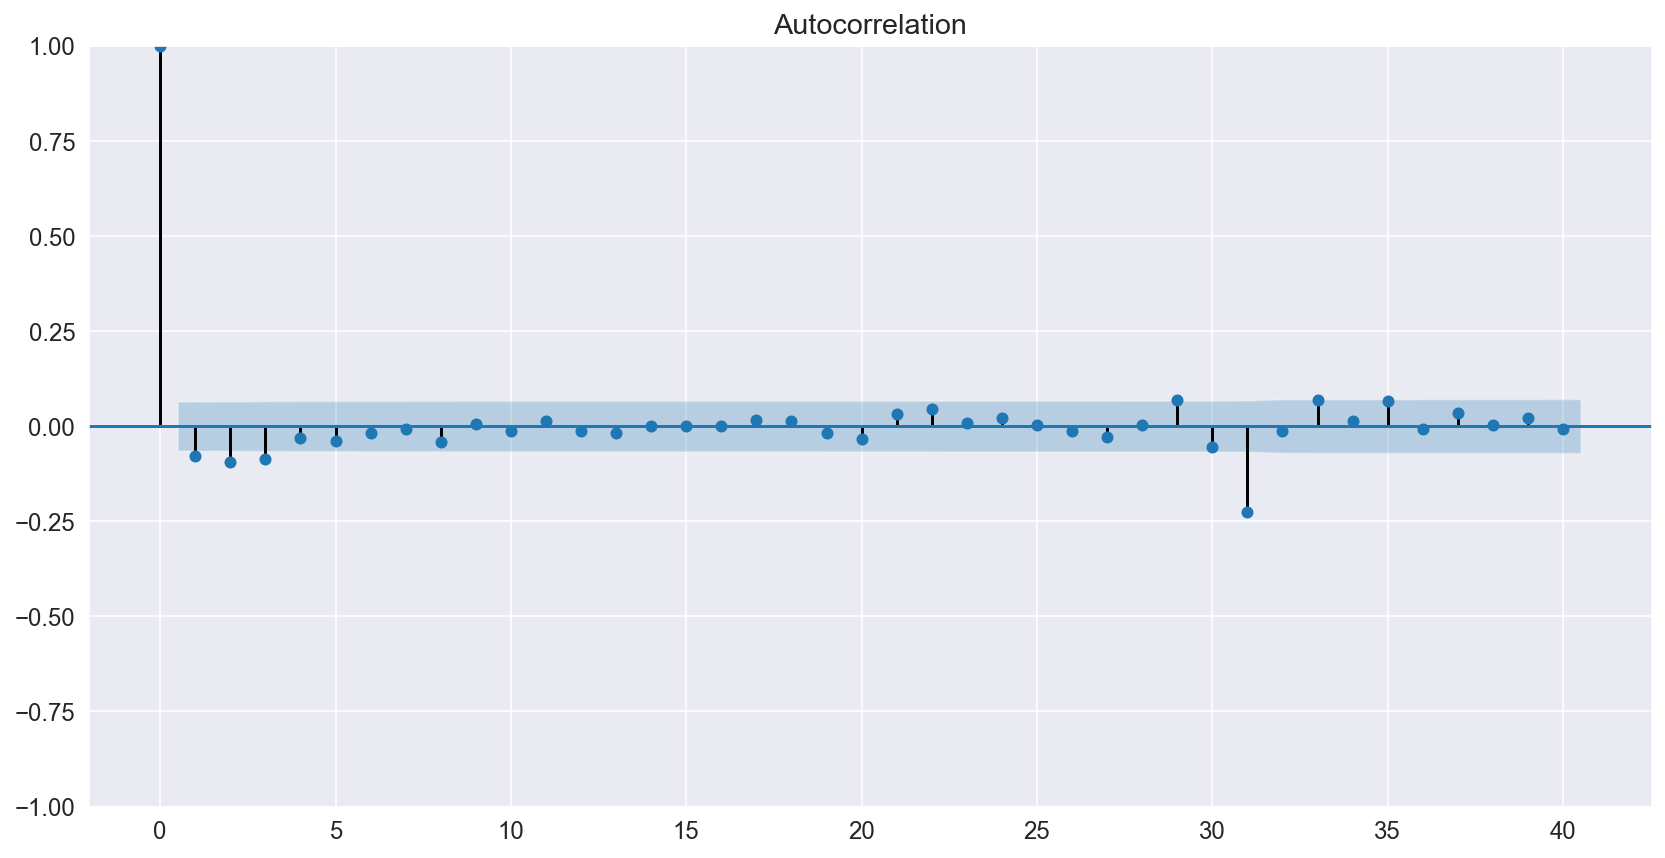

In [27]:
plot_acf(total_res, lags = 40);

In [28]:
# лист лагов с самой высокой корреляцией

lags = [2, 3, 30, 31, 33]

for x in lags:
    p_value = acorr_ljungbox(total_res, x)['lb_pvalue'][1]
    if p_value < 0.05:
        print('p_value={} < 0.05. H0 о независимом распределении остатков отвергается. Остатки корреляруют между собой.'.format(p_value))
    else:
        print('p_value={} > 0.05. H0 о независимом распределении остатков не отвергается. Остатки независимы'.format(p_value))

p_value=0.017630600685595105 < 0.05. H0 о независимом распределении остатков отвергается. Остатки корреляруют между собой.
p_value=0.017630600685595105 < 0.05. H0 о независимом распределении остатков отвергается. Остатки корреляруют между собой.
p_value=0.017630600685595105 < 0.05. H0 о независимом распределении остатков отвергается. Остатки корреляруют между собой.
p_value=0.017630600685595105 < 0.05. H0 о независимом распределении остатков отвергается. Остатки корреляруют между собой.
p_value=0.017630600685595105 < 0.05. H0 о независимом распределении остатков отвергается. Остатки корреляруют между собой.


Бонус! (0.5 балла)

Реализуйте тест Бройша-Годфри. Описание можно почерпнуть из [Википедии](https://en.wikipedia.org/wiki/Breusch–Godfrey_test). Протестируйте остатки на наличие автокорелляций. Изменился ли результат?

##### Результаты и визуализация (0.6 балла)

Соберите в сумму прогнозы всех компонент STL-разложения. Не забудьте на сумму прогнозов компонент применить преобразования, обратные тем, которые были сделаны на трейне.  Визуализируйте прогноз и тестовые данные. Подсчитайте MAE прогноза. Подсчитайте MAE сезонного наивного прогноза (на каждой точке теста -- последнее наблюдение за аналогичный день в предыдущем месяце, 30 дней назад). Справилась ли ваша модель лучше?

In [29]:
# итоговый прогноз как сумма компонент сезонности, ошибки и тренда. 

total_forecast = polynom_prediction + naive_prediction + resid_predict

# в условиях задачи ограничиваю прогноз снизу нулем.

total_forecast.where(total_forecast > 0, other = 0, inplace=True) 

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x246f389b708>)

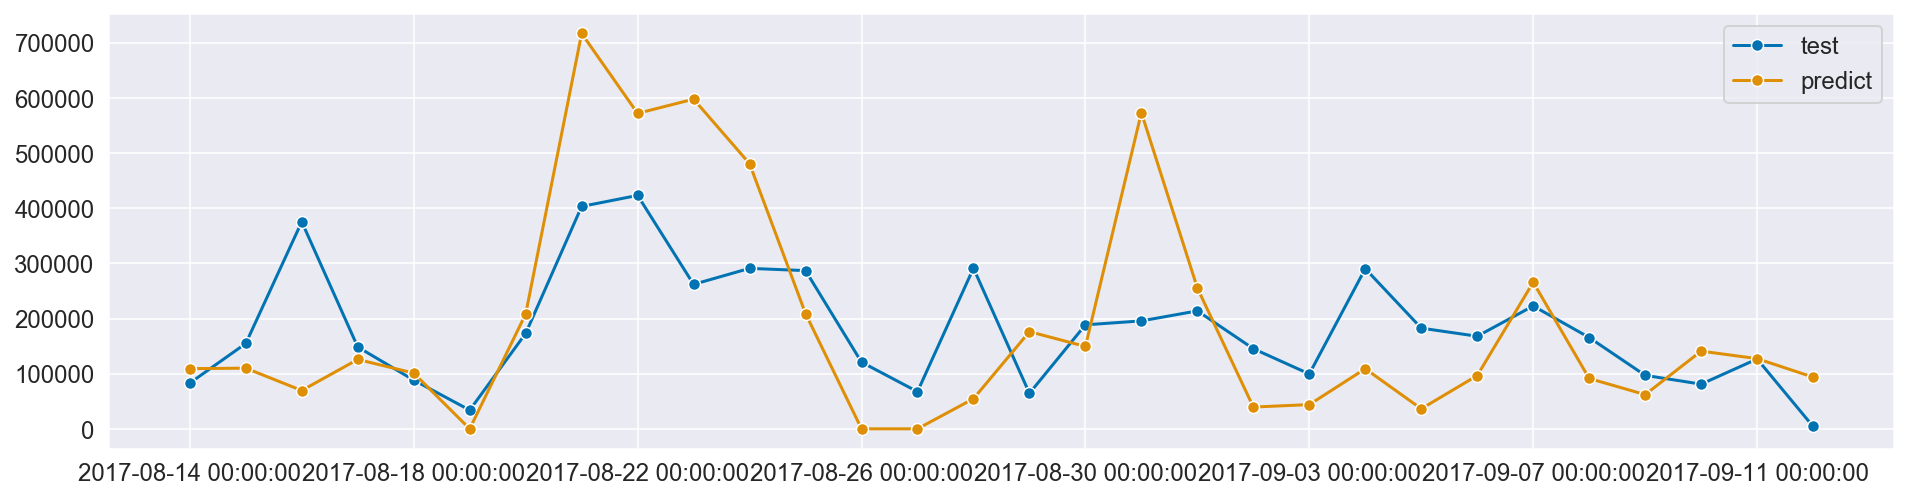

In [30]:
plot_series(y_test, total_forecast, labels = ['test', 'predict'])

In [31]:
# MAE

mean_absolute_error(y_test, total_forecast)

113499.92157345275

In [32]:
mean_absolute_error(y_test, naive_prediction)  # ошибка сезонной наивной модели. 

238993.71576708456

модель справилась лучше наивной

### Блок 2. ETS-модель

Теперь повторим то же самое, только моделировать тренд и сезонность будем одновременно одной ETS-моделью, а на остатки ETS-модели навешивать вторую модель.

##### Визуальный анализ (1 балл)

Вернитесь к y_train. Взгляните на ряд и опишите, какие из вариантов ETS-модели подошли бы под наши данные. Сформируйте сетку параметров для моделей-кандидатов. Кратко поясните каждую опцию, которую вы включаете в сетку, основываясь на визуальном анализе.

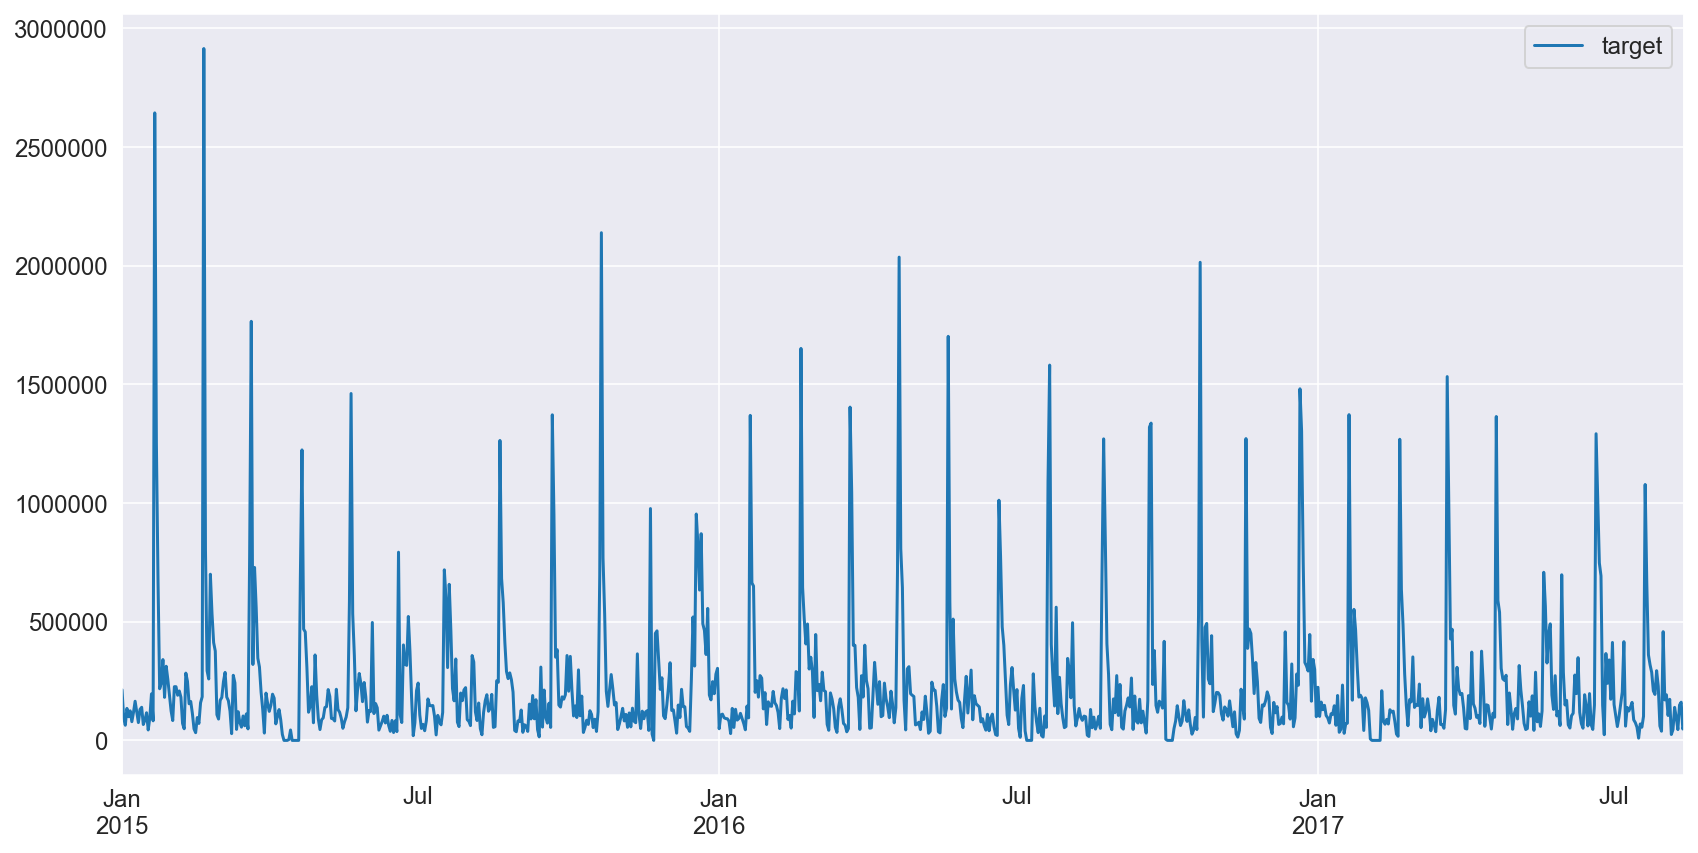

In [33]:
y_train.plot()

param_grid = {
    'trend':['add', None], # тренд слабо выраженный, поэтому либо отсутсвует либо аддитивный
    'seasonal':['add','mul'], # может быть мультипликативной
    'error':['add','mul'], # то же, что и с сезонностью
}

##### Кросс-валидация (0.3 балла)

С помощью кросс-валидации выберите наилучшую по MAE ETS-модель. Обучите её на всём трейне и спрогнозируйте на тест. 

In [34]:
fh = ForecastingHorizon(np.arange(1,31))

forecaster = AutoETS(allow_multiplicative_trend = False, sp = 31)

cv = SlidingWindowSplitter(window_length=200, initial_window = 300, step_length = len(y_test), fh = fh, start_with_window=True)

In [35]:
# обучение лучшей модели с прогнозированием на отложенную выборку. 

gscv = ForecastingGridSearchCV(
    forecaster = forecaster,
    param_grid = param_grid,   
    cv = cv,
    scoring = MeanAbsoluteError(), 
    n_jobs = -1
)

fitted_ets = gscv.fit(y = y_train, fh=fh)
y_predict_ets = fitted_ets.predict()

##### Подготовка данных (0.1 балла)

Достаньте остатки ETS-модели на трейне. Они будут использованы в качестве таргета для второй модели. Можно использовать те же фичи, что и в разделе про STL, без дополнительных пояснений. Результатом пункта должны быть вектор y_train и матрица X_train для модели остатков.

In [36]:
target_resid = fitted_ets.predict_residuals(y=y_train) # у_train

resid_matrix = X_train.copy() # X_train

resid_matrix['y_L1'] = target_resid.shift(1)[31:]
resid_matrix['y_L28'] = target_resid.shift(28)[31:]
resid_matrix['y_L29'] = target_resid.shift(29)[31:]
resid_matrix['y_L30'] = target_resid.shift(30)[31:]
resid_matrix['y_L31'] = target_resid.shift(31)[31:]

target_resid = target_resid[31:]
resid_matrix = resid_matrix.dropna()

##### Отбор моделей остатков и кросс-валидация (0.5 баллов)

Отберите 3-4 модели-кандидата для прогнозирования остатков и отберите на кросс-валидации наилучшую по MAE модель. Размер валидации на каждом фолде всё также равен 30, как длина теста. Используйте реализованный ранее класс для кросс-валидации. 

In [37]:
resid_linmodel_matrix = resid_matrix.copy() # новая матрица объектов-признаков для линейной модели

numeric = resid_linmodel_matrix.loc[:,'Inflation':].columns

resid_linmodel_matrix[numeric] = scaler.fit_transform(resid_linmodel_matrix[numeric]) # масштабирование признаков

In [38]:
linear_model = LinearRegression() # используем линейную регрессию. 

In [39]:
# линейная регрессия

Custom_CrossVal_func(regressor = LinearRegression(), X_train = resid_linmodel_matrix, y_train = target_resid)

Средняя абсолютная ошибка алгоритма: 463710.57


In [40]:
# knn

Custom_CrossVal_func(regressor = KNeighborsRegressor(), X_train = resid_matrix, y_train = target_resid)

Средняя абсолютная ошибка алгоритма: 179424.61


In [41]:
# случайный лес

Custom_CrossVal_func(regressor = RandomForestRegressor(), X_train = resid_matrix, y_train = target_resid)

Средняя абсолютная ошибка алгоритма: 188022.26


##### Прогноз остатков ETS (0.5 баллов)
Обучите наилучшую модель на всём трейне. Постройте прогноз на тест с помощью любой многошаговой стратегии. Как и ранее, проще всего использовать прямую.

In [42]:
regressor = KNeighborsRegressor()
forecaster = make_reduction(regressor, strategy = 'direct')
fh = ForecastingHorizon(np.arange(1,31))

fitted = forecaster.fit(y = target_resid, fh = fh, X = resid_matrix)
resid_ets_predict = fitted.predict()

##### Бэктестинг (0.5 балла)

Класс ETS-модели не позволяет напрямую получить прогноз на трейне. Но позволяет сразу получить остатки на трейне. Возьмите эти остатки и вычтите из них прогноз второй модели. Таким образом вы получите финальные остатки вашей двухуровневой модели. Нарисуйте графики автокорреляций этих остатков. Протестируйте их на наличие серийных автокорреляций любым из тестов, реализованных ранее.

In [43]:
# расчет финальных остатков

knn = KNeighborsRegressor()
knn.fit(y = target_resid, X = resid_matrix)
knn_predict = knn.predict(resid_matrix)

final_residuals_ets  = target_resid - knn_predict

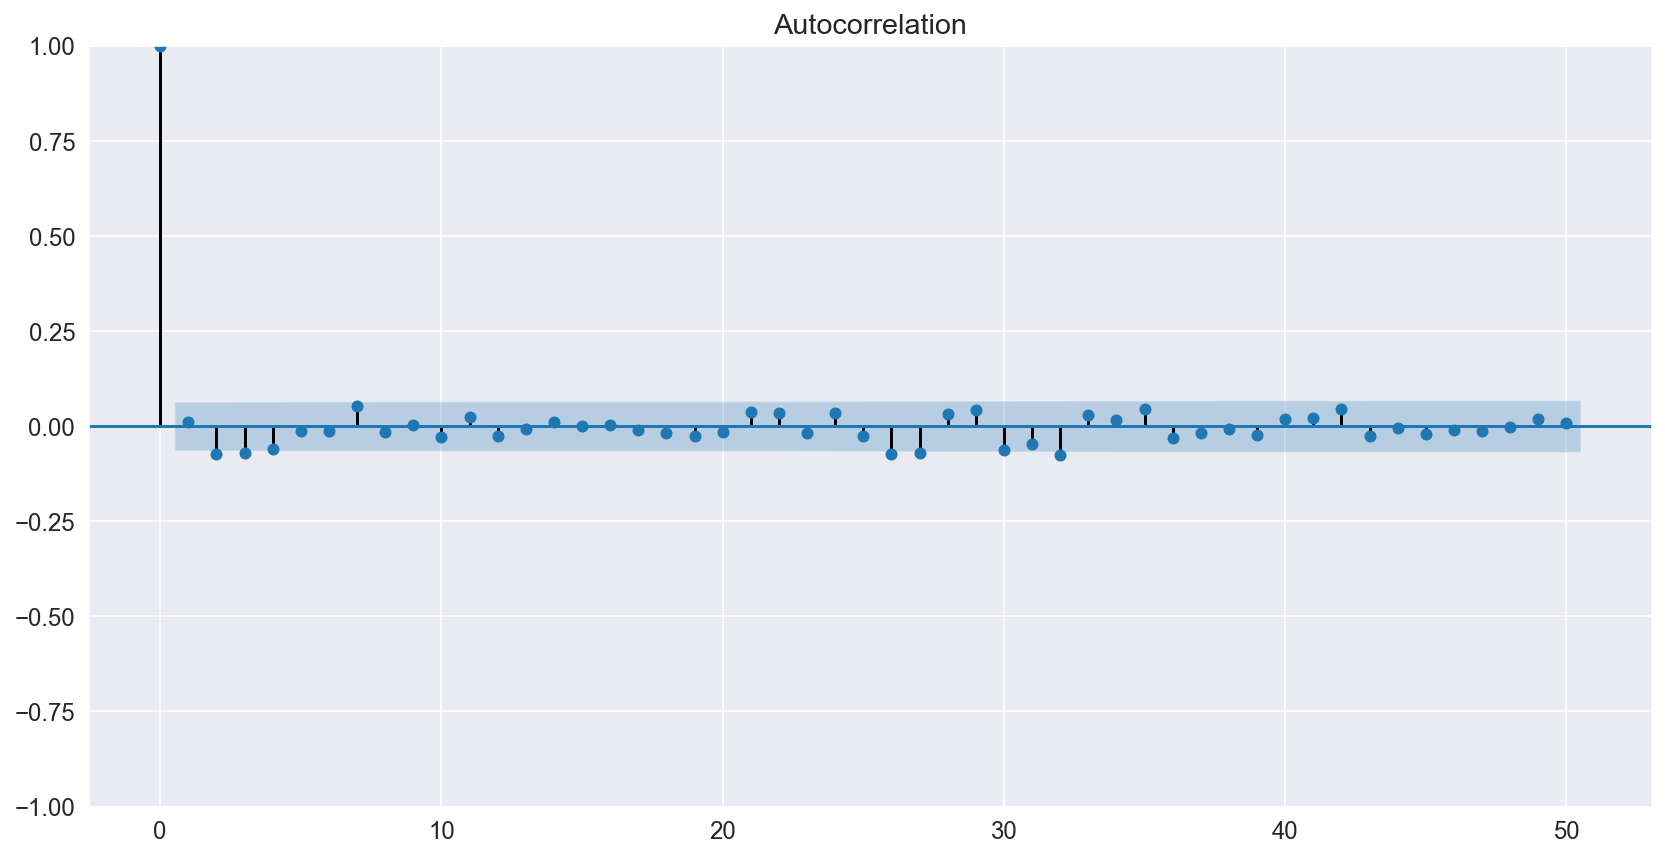

In [44]:
plot_acf(final_residuals_ets, lags=50);

##### Результаты (0.6 балла)

Постройте суммарный прогноз ETS-модели и модели остатков на тесте. Визуализируйте прогноз и тестовые значения на графике. Подсчитайте MAE прогноза. Добавьте на график прогноз модели из Блока 1. Какая из двух моделей получилась лучше? Как думаете, почему? Обе ли модели смогли пробить порог сезонной наивной модели?

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x246f4b36148>)

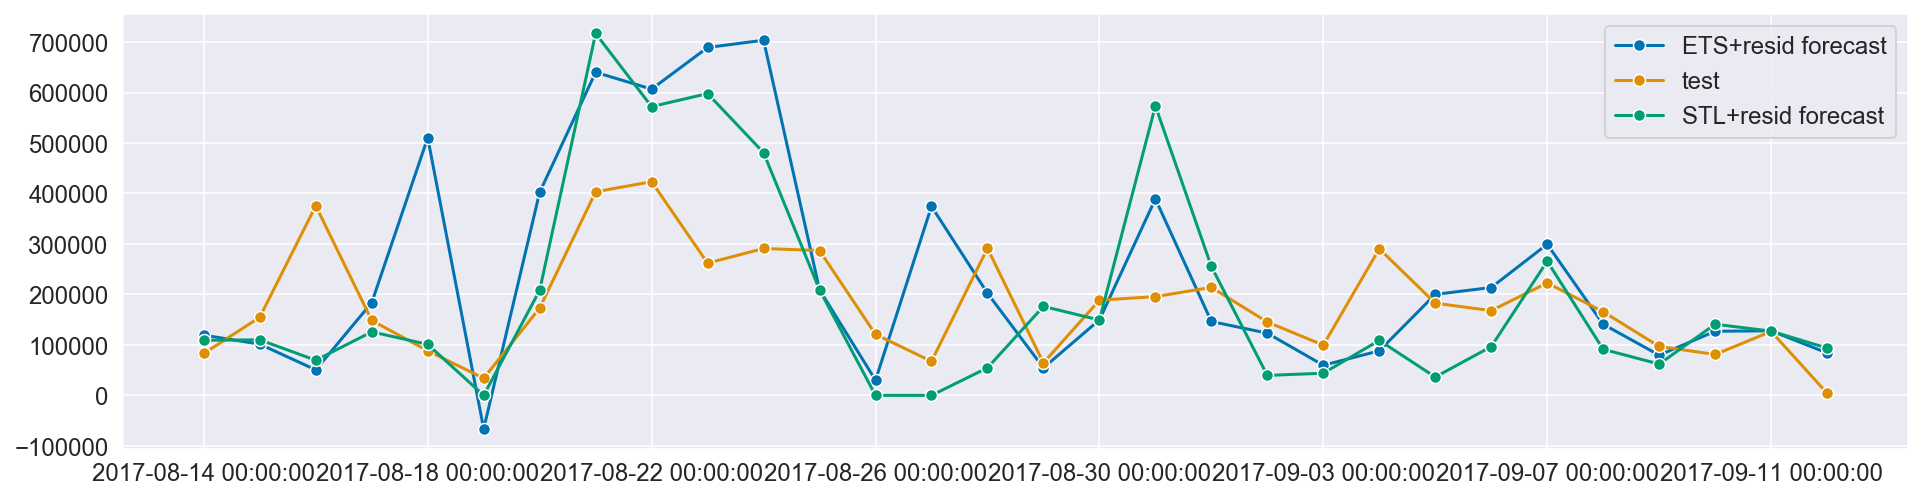

In [45]:
# суммарный прогноз ets и модели остатков на тест.

total = resid_ets_predict + y_predict_ets

plot_series(total, y_test, total_forecast, labels = ['ETS+resid forecast', 'test', 'STL+resid forecast'])

In [46]:
mean_absolute_error(y_test, total)

130289.90548378677

на тестовых данных лучше себя показывает stl модель, ошибка которой меньше по сравнению с ets. С моей точки зрения это объясняется спецификой тестового периода: ряд слабо меняется во времени и, скорее, колеблется около 30000. STL разложение прогнозирует, используя двойное сглаживание, что может быть эффективно в условиях слабо меняющегося ряда. Таким образом, прогноз STL оказывается более точным. 

обе модели пробили порог сезонной наивной модели.

##### Скиньте мем (Бесценно)

In [47]:
# ༼ つ ◕_◕ ༽つ

##### Рубрика "как вам домашка?"

Поделитесь, что вам понравилось, а что нет. Это важно